# Classification

---

### Key Idea:
- Classifying the **success probability** of an anime (rank, popularity, mean, positive_viewership_fraction) based on features of an anime
- We will create a new feature where top 500 ranking, or top 500 popularity, or high mean, or high positive_viewership_fraction as a **`successful` (Yes/No)**
- We will then classify whether an anime will be **`successful` (Yes/No)** according to certain metrics

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [1]:
# Basic Libraries
import json
import statistics
import math

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt  # we only need pyplot

sb.set()  # set the default Seaborn style for graphics

import warnings
warnings.filterwarnings('ignore')

## The different classification models
The following models are inspired from [https://medium.datadriveninvestor.com/choosing-the-best-algorithm-for-your-classification-model-7c632c78f38f]

`Random Forest`
 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier


`Support Vector Classification (SVC)`
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC


`Decision Tree Classifier`
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier


`XGBClassifier`
- https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=xgbclassifier#xgboost.XGBClassifier


---
# Random Forest Classifier
Understand more about Random Forest Algorithm from [https://builtin.com/data-science/random-forest-algorithm]

## How it works
- An ensemble of decision trees
- Building multiple decision trees and merges them together to get a more accurate and stable prediction
- Random Forest adds additonal randomness to the model, while growing the trees
- Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features.
- Only a random subset of the features is taken into consideration by the algorithm for splitting a node
<br>

## Difference compared to Decision Trees
- Random forest algorithm randomly selects observations and features to build several decision trees and then averages the results.
- "deep" decision trees might suffer from overfitting. Most of the time, random forest prevents this by creating random subsets of the features and building smaller trees using those subsets. Afterwards, it combines the subtrees. It's important to note this doesn’t work every time and it also makes the computation slower, depending on how many trees the random forest builds.
<br>

## Feature Importance
- Random forest algorithm is very easy to measure the relative importance of each feature on the prediction
  - Sklearn provides a great tool for this that measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest. It computes this score automatically for each feature after training and scales the results so the sum of all importance is equal to one.
<br>

## Advantages & Disadvantages
- Advantages
  - `Versatility` as it can be used for both regression and classification, and it's easy to view the relative importance it assigns to the input features
  - `Straight forward` and easy to understand hyperparameters
  - `No overfitting` if there are enough trees in the forest
- Disadvantages
  - Large number of trees can make the algorithm too slow and ineffective for real-time predictions
  - Algorithms are fast to train, but quite slow to create predictions once they are trained
  - Trade-off between `accuracy vs speed`
<br>

## Important Hyperparameters
The hyperparameters in random forest are either used to increase the predictive power of the model or to make the model faster. Let's look at the hyperparameters of sklearns built-in random forest function.

### 1. Increasing the predictive power

**`n_estimators`** hyperparameter
 - Which is just the **number of trees** the algorithm builds before taking the maximum voting or taking the averages of predictions. 
 - In general, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation.

**`max_features`** hyperparameter
- Which is the **maximum number of features** random forest considers to **split a node.**
- Sklearn provides several options, all described in the documentation.

**`min_sample_leaf`** hyperparameter
- This determines the **minimum number of leafs** required to **split an internal node.**

### 2. Increasing the model's speed

**`n_jobs`** hyperparameter
- Tells the engine **how many processors** it is allowed to use. 
- If it has a value of one, it can only use one processor. A value of “-1” means that there is no limit.

**`random_state`** hyperparameter
- Makes the **model’s output replicable.**
- The model will always produce the same results when it has a definite value of random_state and if it has been given the same hyperparameters and the same training data.

**`oob_score`** hyperparameter (also called oob sampling)
- Which is a random forest **cross-validation method.**
- In this sampling, about one-third of the data is not used to train the model and can be used to evaluate its performance. These samples are called the out-of-bag samples. It's very similar to the leave-one-out-cross-validation method, but almost no additional computational burden goes along with it.

---

## Import Random Forest Classifier

In [2]:
from sklearn.ensemble import RandomForestClassifier

## Importing the data

In [51]:
anime_df = pd.read_csv('dataset/anime_cleaned_2.csv')
print("Number of animes:", len(anime_df))
anime_df.head(1)

Number of animes: 8661


,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,num_scoring_users,...,broadcast_day_of_the_week,broadcast_start_time,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction
0,95,Turn A Gundam,1999-04-09,2000-04-14,"It is the Correct Century, two millennia after...",7.71,1049,2892,40743,13338,...,friday,17:00,2735.0,16661.0,2538.0,1597.0,17292.0,40823.0,0.8987,0.1013


## Dropping non-essential columns to classification

In [52]:
anime_df.drop([
    'title', 'start_date', 'end_date', 'id', 'synopsis',
    'num_list_users', 'num_scoring_users', 'broadcast_day_of_the_week',
    'broadcast_start_time', 'statistics_watching', 'statistics_completed',
    'statistics_on_hold', 'statistics_dropped', 'statistics_plan_to_watch',
    'statistics_num_list_users', 'negative_viewership_fraction'
],
              axis=1,
              inplace=True)


In [53]:
anime_df.head(1)

,mean,rank,popularity,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,start_season_year,start_season_season,positive_viewership_fraction
0,7.71,1049,2892,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",50,original,1445,pg_13,"[{'id': 14, 'name': 'Sunrise'}, {'id': 1260, '...",1999.0,spring,0.8987


## Create new feature `success` to classify success of anime
- 0: Not Successful
- 1: Successful
  - Top 500 `rank`
  - Top 500 `popularity`
  - `mean`above 8.5
  - `positive_viewership_fraction` above 0.975

In [46]:
len(anime_df[anime_df['rank'] <= 500]['rank'])

986

In [54]:
len(anime_df[anime_df['positive_viewership_fraction'] >= 0.975]['positive_viewership_fraction'])

1246

In [92]:
# create 'success' column
for row in range(len(anime_df)):
    success = (anime_df['rank'][row] <= 500 or
              anime_df['popularity'][row] <= 500 or
              anime_df['mean'][row] >= 8.5 or
              anime_df['positive_viewership_fraction'][row] >= 0.975)
    
    if success:
        anime_df['success'][row] = 1
    else:
        anime_df['success'][row] = 0
    

<ipython-input-92-149c0ee13dc0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['success'][row] = 0
<ipython-input-92-149c0ee13dc0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['success'][row] = 1


In [94]:
anime_df.head()

,mean,rank,popularity,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,start_season_year,start_season_season,positive_viewership_fraction,success
0,7.71,1049,2892,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",50,original,1445,pg_13,"[{'id': 14, 'name': 'Sunrise'}, {'id': 1260, '...",1999.0,spring,0.8987,0.0
1,8.07,472,4347,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 8, 'name'...",28,novel,1560,r,"[{'id': 8, 'name': 'Artland'}, {'id': 207, 'na...",1999.0,fall,0.9479,1.0
2,7.74,976,2553,white,tv,finished_airing,"[{'id': 2, 'name': 'Adventure'}, {'id': 4, 'na...",1787,manga,660,pg,"[{'id': 247, 'name': 'Shin-Ei Animation'}]",1979.0,spring,0.7589,0.0
3,8.63,66,26,white,tv,currently_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",0,manga,1440,pg_13,"[{'id': 18, 'name': 'Toei Animation'}]",1999.0,fall,0.7816,1.0
4,7.77,924,2135,white,movie,finished_airing,"[{'id': 2, 'name': 'Adventure'}, {'id': 4, 'na...",1,original,2460,pg,"[{'id': 18, 'name': 'Toei Animation'}]",2000.0,winter,0.9915,1.0


In [102]:
print("Number of not successful animes:", len(anime_df[anime_df['success'] == 0]['success']))
print("Number of successful animes:\t", len(anime_df[anime_df['success'] == 1]['success']))

Number of not successful animes: 6287
Number of successful animes:	 2374


## Unravel `genres` and `studios` from one column to multiple columns

In [103]:
from ipynb.fs.full.helpers import json_genres, json_studios

anime_df = json_genres(anime_df)  # convert genres column to json
anime_df = json_studios(anime_df)  # convert studios column to json

C:\Users\Toh Jing Qiang\Desktop\Jing Qiang Programming Projects\NTU Programming\SC1015\SC1015-Project\Anime\helpers.ipynb:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",
C:\Users\Toh Jing Qiang\Desktop\Jing Qiang Programming Projects\NTU Programming\SC1015\SC1015-Project\Anime\helpers.ipynb:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "outputs": [],


In [104]:
def unravel_genre_or_studio(row):
    res = pd.Series(dtype=str)
    for elem in row:
        res = res.append(pd.Series([elem['name']]))
    res.reset_index(inplace=True, drop=True)
    return res


genres_expanded = anime_df['genres'].apply(
    lambda row: unravel_genre_or_studio(row))
genres_expanded

,0,1,2,3,4,5,6,7,8,9,10
0,Action,Adventure,Drama,Mecha,Military,Romance,Sci-Fi,Space,NaN,NaN,NaN
1,Action,Drama,Military,Sci-Fi,Space,NaN,NaN,NaN,NaN,NaN,NaN
2,Adventure,Comedy,Fantasy,Kids,Sci-Fi,Shounen,NaN,NaN,NaN,NaN,NaN
3,Action,Adventure,Comedy,Drama,Fantasy,Shounen,Super Power,NaN,NaN,NaN,NaN
4,Adventure,Comedy,Kids,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8656,Music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8657,Comedy,Slice of Life,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8658,Adventure,Comedy,Demons,Fantasy,Historical,Supernatural,NaN,NaN,NaN,NaN,NaN
8659,Music,Supernatural,Vampire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
genres_expanded = genres_expanded.fillna('NA')

In [106]:
studios_expanded = anime_df['studios'].apply(
    lambda row: unravel_genre_or_studio(row))
studios_expanded = studios_expanded.fillna('NA')
studios_expanded

,0,1,2,3,4,5,6,7,8,9
0,Sunrise,Nakamura Production,NA,NA,NA,NA,NA,NA,NA,NA
1,Artland,Magic Bus,NA,NA,NA,NA,NA,NA,NA,NA
2,Shin-Ei Animation,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Toei Animation,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Toei Animation,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...
8656,Doga Kobo,NA,NA,NA,NA,NA,NA,NA,NA,NA
8657,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8658,Sunrise,NA,NA,NA,NA,NA,NA,NA,NA,NA
8659,A-1 Pictures,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [107]:
anime_expanded_df = anime_df.copy()
for index, row in genres_expanded.iterrows():
    for i in genres_expanded.columns:
        anime_expanded_df.loc[index, f"genre-{i}"] = genres_expanded.iloc[index, i]
for index, row in studios_expanded.iterrows():
    for i in studios_expanded.columns:
        anime_expanded_df.loc[index, f"studio-{i}"] = studios_expanded.iloc[index, i]


In [108]:
anime_expanded_df.head(2)

,mean,rank,popularity,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,...,studio-0,studio-1,studio-2,studio-3,studio-4,studio-5,studio-6,studio-7,studio-8,studio-9
0,7.71,1049,2892,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",50,original,1445,...,Sunrise,Nakamura Production,NA,NA,NA,NA,NA,NA,NA,NA
1,8.07,472,4347,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 8, 'name'...",28,novel,1560,...,Artland,Magic Bus,NA,NA,NA,NA,NA,NA,NA,NA


### Encoding nominal (unordered) categorical variables using `OneHotEncoding`

Our dataset contains a lot of categorical variables such as:
- media_type
- source
- rating
- start_season_season
- start_season_year
- status
- nsfw
- genres
- studios

In [109]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
cat_variables = [
    'media_type', 'source', 'rating', 'start_season_season',
    'start_season_year', 'status', 'nsfw'
] + [f"genre-{i}" for i in genres_expanded.columns] + [f"studio-{i}" for i in studios_expanded.columns]
anime_cat = anime_expanded_df[cat_variables]

ohe.fit(anime_cat)
anime_cat_ohe = pd.DataFrame(ohe.transform(anime_cat).toarray(),
                             columns=ohe.get_feature_names(anime_cat.columns))

# Check the encoded variables
anime_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8661 entries, 0 to 8660
Columns: 917 entries, media_type_movie to studio-9_Steve N' Steven
dtypes: float64(917)
memory usage: 60.6 MB


In [110]:
num_variable = []
for i in anime_df:
    if i not in cat_variables:
        num_variable.append(i)
num_variable

['mean',
 'rank',
 'popularity',
 'genres',
 'num_episodes',
 'average_episode_duration',
 'studios',
 'positive_viewership_fraction',
 'success']

In [111]:
# Combining Numeric features with the OHE Categorical features
animeData_num = anime_df[num_variable]
animeData_ohe = pd.concat([animeData_num, anime_cat_ohe],
                          sort=False,
                          axis=1).reindex(index=animeData_num.index)

# Check the final dataframe
animeData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8661 entries, 0 to 8660
Columns: 926 entries, mean to studio-9_Steve N' Steven
dtypes: float64(920), int64(4), object(2)
memory usage: 61.2+ MB


In [113]:
animeData_ohe.head(2)

,mean,rank,popularity,genres,num_episodes,average_episode_duration,studios,positive_viewership_fraction,success,media_type_movie,...,studio-5_Trigger,studio-6_Graphinica,studio-6_NA,studio-6_Science SARU,studio-7_NA,studio-7_Studio Colorido,studio-8_NA,studio-8_Sola Digital Arts,studio-9_NA,studio-9_Steve N' Steven
0,7.71,1049,2892,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",50,1445,"[{'id': 14, 'name': 'Sunrise'}, {'id': 1260, '...",0.8987,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,8.07,472,4347,"[{'id': 1, 'name': 'Action'}, {'id': 8, 'name'...",28,1560,"[{'id': 8, 'name': 'Artland'}, {'id': 207, 'na...",0.9479,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [116]:
# All the columns
for col in animeData_ohe.columns:
    print(col)

mean
rank
popularity
genres
num_episodes
average_episode_duration
studios
positive_viewership_fraction
success
media_type_movie
media_type_music
media_type_ona
media_type_ova
media_type_special
media_type_tv
source_4_koma_manga
source_book
source_card_game
source_digital_manga
source_game
source_light_novel
source_manga
source_mixed_media
source_music
source_novel
source_original
source_other
source_picture_book
source_radio
source_unknown
source_visual_novel
source_web_manga
source_web_novel
rating_g
rating_no_rating
rating_pg
rating_pg_13
rating_r
rating_r+
start_season_season_fall
start_season_season_spring
start_season_season_summer
start_season_season_winter
start_season_year_1969.0
start_season_year_1979.0
start_season_year_1988.0
start_season_year_1992.0
start_season_year_1993.0
start_season_year_1994.0
start_season_year_1995.0
start_season_year_1996.0
start_season_year_1997.0
start_season_year_1998.0
start_season_year_1999.0
start_season_year_2000.0
start_season_year_2001.0
sta

---
# Metrics to measure performance

In [444]:
def model_performance(random_forest, X_train, X_test, y_train, y_test):
    # Import libraries
    from sklearn.model_selection import cross_val_predict
    from sklearn.model_selection import cross_val_score
    
    # K-Fold Cross Validation
    y_train_pred = cross_val_predict(random_forest, X_train, y_train, cv=5)
    y_test_pred = cross_val_predict(random_forest, X_test, y_test, cv=5)
    
    train_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring = "accuracy")
    test_scores = cross_val_score(random_forest, X_test, y_test, cv=5, scoring = "accuracy")
    
    # Performance metrics
    #confusion_matrix_TPR_TNR(y_train, y_test, y_train_pred, y_test_pred, train_scores, test_scores)
    
    
    
    print("-> Train Dataset")
    confusion_matrix_TPR_TNR(y_train, y_train_pred, train_scores, "Train")
    get_precision_recall(y_train, y_train_pred)
    get_f1_score(y_train, y_train_pred)
    ROC_AUC(random_forest, X_train, y_train, "Train")

    print("\n\n-----\n-> Test Dataset")
    confusion_matrix_TPR_TNR(y_test, y_test_pred, test_scores, "Test")
    get_precision_recall(y_test, y_test_pred)
    get_f1_score(y_test, y_test_pred)
    ROC_AUC(random_forest, X_test, y_test, "Test")
    print('-----\n')
    
    get_oob_score(random_forest)
    

## Confusion Matrix:
- True Positive Rate
- True Negative Rate
We are looking at the TPR and TNR because we want to know how confident are we with the result of the classification

In [375]:
def confusion_matrix_TPR_TNR(y, y_pred, scores, train_test_string):
    from sklearn.metrics import confusion_matrix
    
    # Confusion Matrix
    c_matrix = confusion_matrix(y, y_pred)

    # True Negatives & True Positives
    TN = c_matrix[0][0]
    FP = c_matrix[1][0]
    FN = c_matrix[0][1]
    TP = c_matrix[1][1]

    # True Positive Rate and True Negative Rate
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)

    # Check the Goodness of Fit (on Train Data)
    print(f"Goodness of Fit of Model ({train_test_string} Dataset)")
    print("Classification Accuracy:", scores.mean())
    print("True Positive Rate:", TPR)
    print("True Negative Rate:", TNR)

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 8))
    sb.heatmap(c_matrix, 
               annot = True, 
               fmt=".0f", 
               annot_kws={"size": 18}).set(title=f"Confusion Matrix ({train_test_string} Dataset)")
    print()

## Precision and Recall:
- `Precision`: Probability of predicting positive correctly (Positive Predictive Value) -> TP/(TP+FP)
- `Recall` (True Positive Rate)

In [354]:
def get_precision_recall(y, y_pred):
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    print("Precision:", precision)
    print("Recall:", recall)
    
    return [precision, recall]

## F-score
- Take into account both precision and recall, with more weight assigned to the lower value

In [355]:
def get_f1_score(y, y_pred):
    from sklearn.metrics import f1_score
    
    f1 = f1_score(y, y_pred)
    
    print("f1_score:", f1)
    
    return f1

## Out-of-bag (oob) score

In [389]:
def get_oob_score(random_forest):
    print("oob score:", round(random_forest.oob_score_ * 100, 2), "%")

## ROC AUC Curve
- Curve plots TPR (recall) vs FPR
- The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC
- A classifiers that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.


- The red line in the middle represents a purely random classifier (e.g a coin flip) and therefore your classifier should be as far away from it as possible

In [443]:
def ROC_AUC(random_forest, X_train, y_train, train_test):
    # getting the probabilities of our predictions
    y_scores = random_forest.predict_proba(X_train)
    y_scores = y_scores[:,1]

    from sklearn.metrics import roc_curve
    # compute true positive rate and false positive rate
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
    
    # plotting them against each other
    def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'r', linewidth=4)
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate (FPR)', fontsize=16)
        plt.ylabel('True Positive Rate (TPR)', fontsize=16)
        plt.title(f'{train_test} Dataset')

    plt.figure(figsize=(14, 7))
    plot_roc_curve(false_positive_rate, true_positive_rate)
    plt.show()
    
    
    # ROC AUC Score
    from sklearn.metrics import roc_auc_score
    r_a_score = roc_auc_score(y_train, y_scores)
    print("ROC-AUC-Score:", r_a_score)

---
# Random Forest Classifier (V1)
- Using all features

In [501]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['success'])
X = pd.DataFrame(animeData_ohe.drop(['success', 'mean', 'rank', 'popularity', 'positive_viewership_fraction', 'genres', 'studios'], axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [481]:
print("Length")
print(f"X_train:\t {len(X_train)}")
print(f"X_test: \t {len(X_test)}")
print(f"y_train:\t {len(y_train)}")
print(f"y_test: \t {len(y_test)}")

Length
X_train:	 6062
X_test: 	 2599
y_train:	 6062
y_test: 	 2599


In [482]:
X_train.head(3)

,num_episodes,average_episode_duration,media_type_movie,media_type_music,media_type_ona,media_type_ova,media_type_special,media_type_tv,source_4_koma_manga,source_book,...,studio-5_Trigger,studio-6_Graphinica,studio-6_NA,studio-6_Science SARU,studio-7_NA,studio-7_Studio Colorido,studio-8_NA,studio-8_Sola Digital Arts,studio-9_NA,studio-9_Steve N' Steven
565,0,1440,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8621,0,600,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4041,97,1405,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [483]:
y_train.head(3)

,success
565,1.0
8621,0.0
4041,0.0


In [502]:
# Random Forest
random_forest_v1 = RandomForestClassifier(n_estimators=100, oob_score=True)
random_forest_v1.fit(X_train, y_train)

y_pred = random_forest_v1.predict(X_test)

random_forest_v1.score(X_train, y_train)
acc_random_forest_v1 = round(random_forest_v1.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest_v1, 2), "%")


acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of {random_forest_v1} is {acc}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix of {random_forest_v1} is {cm}")

100.0 %
Accuracy of RandomForestClassifier(oob_score=True) is 0.8857252789534437
Confusion Matrix of RandomForestClassifier(oob_score=True) is [[1803   67]
 [ 230  499]]


In [503]:
acc_random_forest_v1 = round(random_forest_v1.score(X_test, y_test) * 100, 2)
print(round(acc_random_forest_v1, 2), "%")

88.57 %


## K-Fold Cross Validation:
- **K=5**

In [504]:
scores = cross_val_score(random_forest_v1, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.87469085 0.88458368 0.87211221 0.8679868  0.88943894]
Mean: 0.8777624959528104
Standard Deviation: 0.007997411256761684


## Test performance of `random_forest_v1` using confusion matrix, precision, recall, and f-scores

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8802380155575327
True Positive Rate: 0.8633836378077839
True Negative Rate: 0.8838226108682073

Precision: 0.8633836378077839
Recall: 0.660790273556231
f1_score: 0.7486225895316804


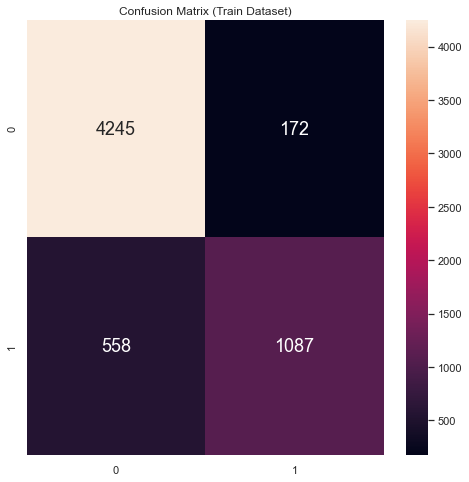

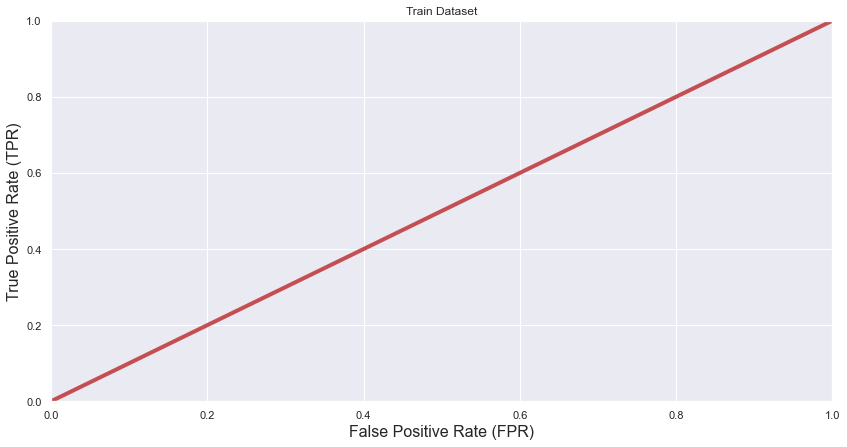

ROC-AUC-Score: 1.0


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8549466429524232
True Positive Rate: 0.845360824742268
True Negative Rate: 0.8491012298959318

Precision: 0.845360824742268
Recall: 0.5624142661179699
f1_score: 0.6754530477759473


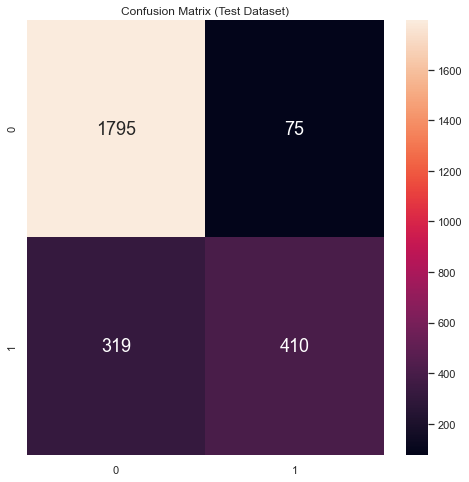

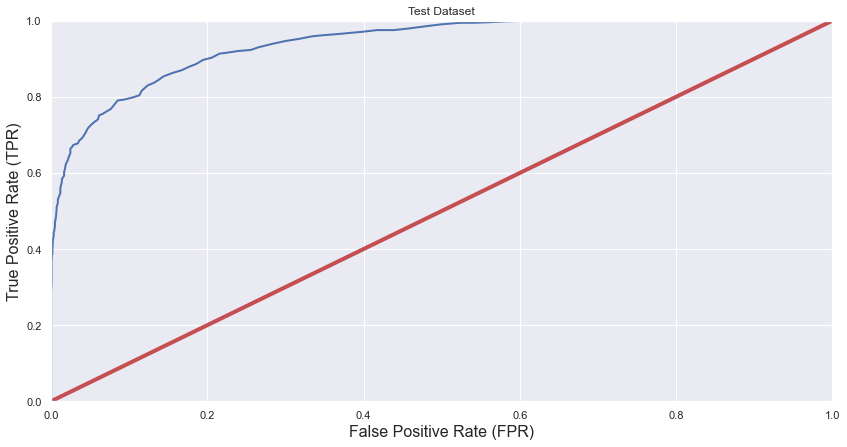

ROC-AUC-Score: 0.9405771586599473
-----

oob score: 88.42 %


In [505]:
model_performance(random_forest_v1, X_train, X_test, y_train, y_test)

- Lets improve the random forest's performance even more

<br>

---
# Feature Importance:
- Sklearn measure features importance by looking at how much the tree nodes, that use that feature and reduce impurity on average (across all trees in the forest). 
- The score is scaled such that the sum of all important feature is equal to 1.

In [458]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance',ascending=False).reset_index(drop=True)

In [459]:
importances.head(15)

,feature,importance
0,average_episode_duration,0.071
1,num_episodes,0.054
2,source_manga,0.020
3,rating_pg_13,0.016
4,media_type_tv,0.016
5,media_type_movie,0.015
6,genre-3_NA,0.014
7,start_season_season_spring,0.014
8,genre-4_NA,0.014
9,rating_g,0.013


<AxesSubplot:xlabel='feature'>

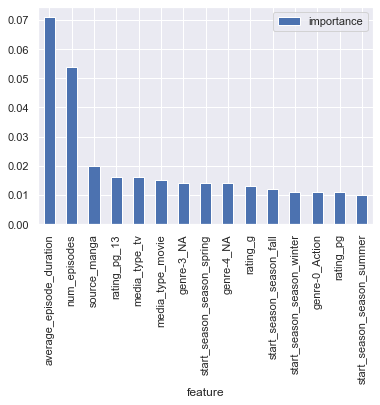

In [460]:
importances.head(15).plot.bar(x='feature', y='importance')

### Features with zero importance:

In [461]:
importances.tail(15)

,feature,importance
904,studio-0_Felix Film,0.0
905,studio-0_Flat Studio,0.0
906,studio-0_Flint Sugar,0.0
907,studio-0_Future Planet,0.0
908,studio-0_G&G Entertainment,0.0
909,studio-0_G-angle,0.0
910,studio-0_GEEK TOYS,0.0
911,studio-0_Gaina,0.0
912,studio-0_Gainax Kyoto,0.0
913,studio-0_Gathering,0.0


In [462]:
zero_importance_features = []
for row in range(len(importances)):
    if importances['importance'][row] == 0:
        zero_importance_features.append(importances['feature'][row])
        
print('Number of features with 0 importance:', len(zero_importance_features))
print('Number of features with some importance:', len(importances) - len(zero_importance_features))

Number of features with 0 importance: 659
Number of features with some importance: 260


**Note:**
- **600+** features does not play a significant role in the random forest classifier prediction process.
- Thus, they can be dropped from the dataset that is used to train the classifier

---
# Random Forest Classifier (V2)
- Dropped features with 0 importances

In [463]:
cols_to_drop = ['success', 'mean', 'rank', 'popularity', 'positive_viewership_fraction', 'genres', 'studios']
cols_to_drop.extend([col for col in zero_importance_features])
cols_to_drop

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['success'])
X = pd.DataFrame(animeData_ohe.drop(cols_to_drop, axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [464]:
X_train.head(3)

,num_episodes,average_episode_duration,media_type_movie,media_type_music,media_type_ona,media_type_ova,media_type_special,media_type_tv,source_4_koma_manga,source_game,...,studio-0_Yumeta Company,studio-0_Zexcs,studio-0_ufotable,studio-1_A-1 Pictures,studio-1_Bridge,studio-1_Egg Firm,studio-1_Madhouse,studio-1_NA,studio-1_Satelight,studio-2_NA
8552,9,953,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4512,2,1220,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4714,58,1220,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [465]:
# Random Forest
random_forest_v2 = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest_v2.fit(X_train, y_train)

y_pred = random_forest_v2.predict(X_test)

random_forest_v2.score(X_train, y_train)
acc_random_forest_v2 = round(random_forest_v2.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest_v2,2,), "%")


acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(random_forest_v2, acc))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix of %s is %s"%(random_forest_v2, cm))

100.0 %
Accuracy of RandomForestClassifier(oob_score=True) is 0.8888033859176606
Confusion Matrix of RandomForestClassifier(oob_score=True) is [[1803   80]
 [ 209  507]]


In [466]:
acc_random_forest_v2 = round(random_forest_v2.score(X_test, y_test) * 100, 2)
print(round(acc_random_forest_v2,2,), "%")

88.88 %


### K-Fold Cross Validation:
- **K=5**

In [467]:
scores = cross_val_score(random_forest_v2, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.88458368 0.86974444 0.87211221 0.87788779 0.8960396 ]
Mean: 0.8800735432158222
Standard Deviation: 0.009487962913111957


## Test performance of `random_forest_v2` using confusion matrix, precision, recall, and f-scores

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8794134772092213
True Positive Rate: 0.8478915662650602
True Negative Rate: 0.8876214617659485

Precision: 0.8478915662650602
Recall: 0.6791314837153196
f1_score: 0.754186202277294


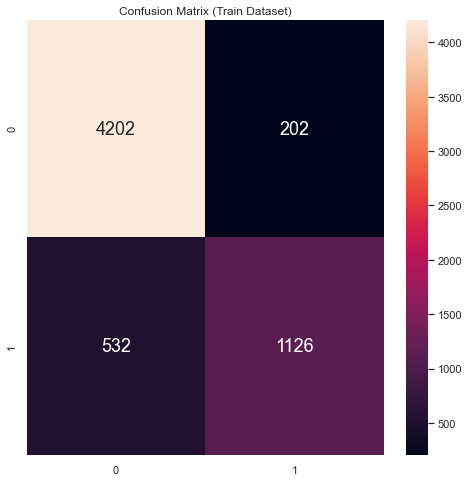

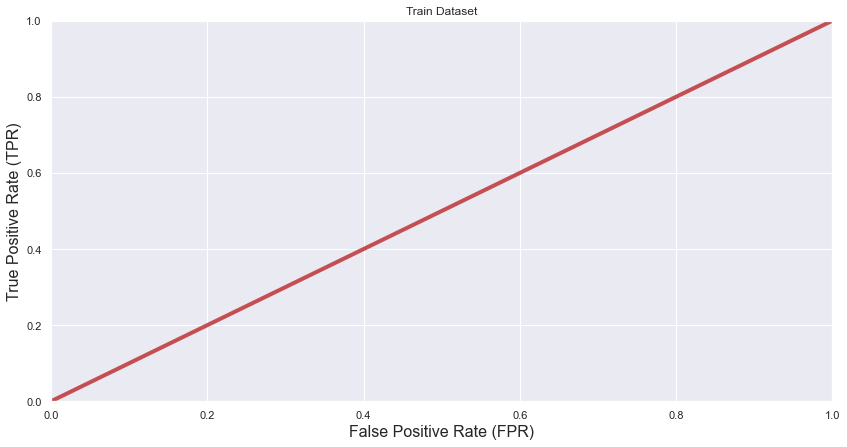

ROC-AUC-Score: 1.0


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.850712168371128
True Positive Rate: 0.8240917782026769
True Negative Rate: 0.8627167630057804

Precision: 0.8240917782026769
Recall: 0.6019553072625698
f1_score: 0.6957223567393059


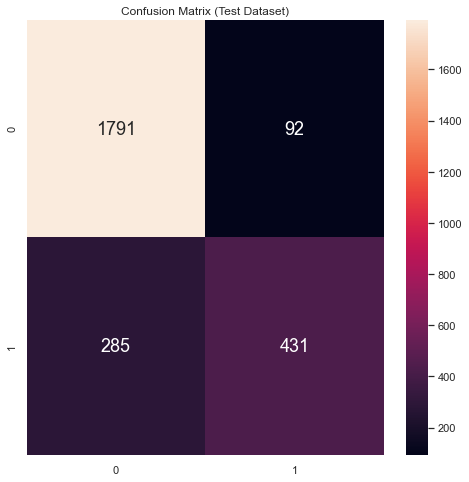

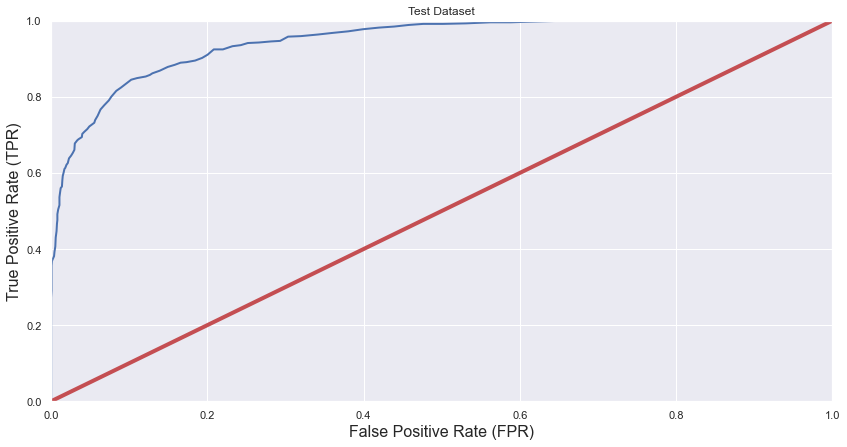

ROC-AUC-Score: 0.9457710416932448
-----

oob score: 88.01 %


In [468]:
model_performance(random_forest_v2, X_train, X_test, y_train, y_test)

**V2 Conclusion:**
- Not much difference, only the performance on test dataset is slightly reduced

---
# Random Forest Classifier (V3)
- Using top 50 important features

In [469]:
# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['success'])
X = pd.DataFrame(animeData_ohe[list(importances['feature'].head(50))]) # Top 50 important features

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [470]:
# Random Forest
random_forest_v3 = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest_v3.fit(X_train, y_train)

y_pred = random_forest_v3.predict(X_test)

random_forest_v3.score(X_train, y_train)
acc_random_forest_v3 = round(random_forest_v3.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest_v3, 2), "%")

##
acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(random_forest_v3, acc))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix of %s is %s"%(random_forest_v3, cm))

99.92 %
Accuracy of RandomForestClassifier(oob_score=True) is 0.8749519045786841
Confusion Matrix of RandomForestClassifier(oob_score=True) is [[1774  106]
 [ 219  500]]


In [471]:
acc_random_forest_v3 = round(random_forest_v3.score(X_test, y_test) * 100, 2)
print(round(acc_random_forest_v3,2,), "%")

87.5 %


### K-Fold Cross Validation:
- **K=5**

In [472]:
scores = cross_val_score(random_forest_v3, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.86644683 0.85902721 0.87046205 0.86386139 0.85643564]
Mean: 0.8632466214469756
Standard Deviation: 0.005037350337381811


## Test performance of `random_forest_v3` using confusion matrix, precision, recall, and f-scores

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8690209746448676
True Positive Rate: 0.8049311094996374
True Negative Rate: 0.8836216100790092

Precision: 0.8049311094996374
Recall: 0.6706948640483383
f1_score: 0.7317073170731707


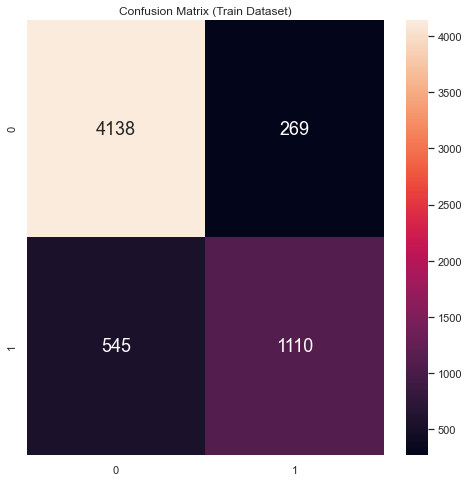

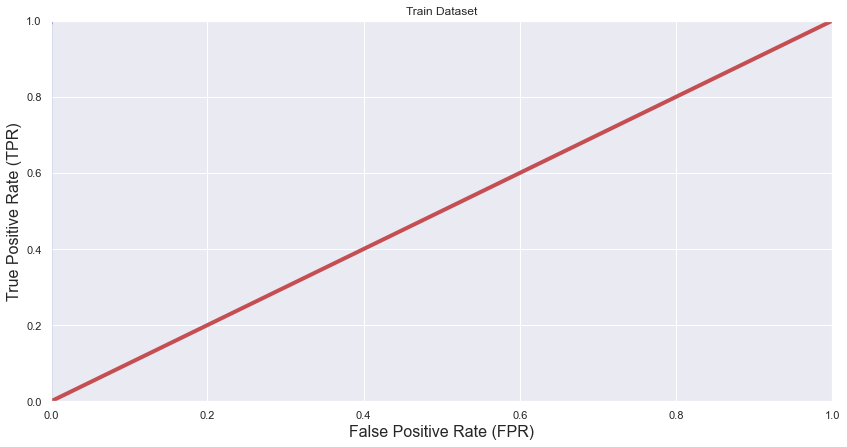

ROC-AUC-Score: 0.9999932132140777


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8414769527197272
True Positive Rate: 0.7769911504424779
True Negative Rate: 0.8623402163225172

Precision: 0.7769911504424779
Recall: 0.6105702364394993
f1_score: 0.6838006230529595


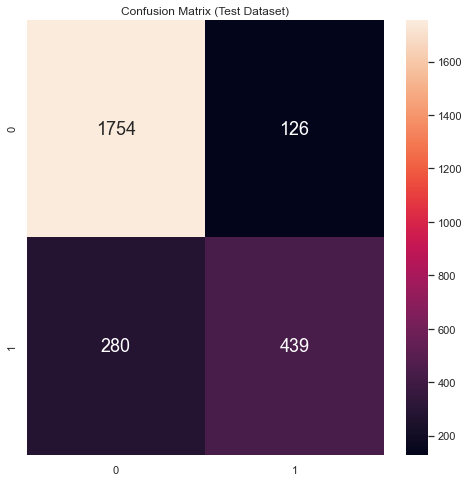

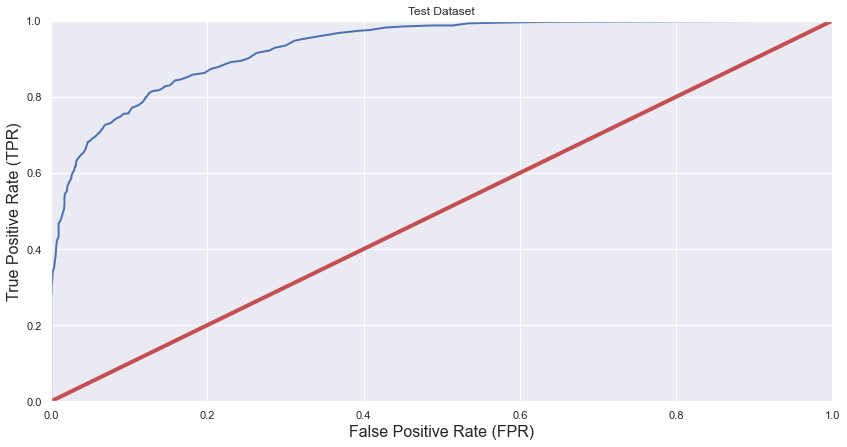

ROC-AUC-Score: 0.9299536886337408
-----

oob score: 87.07 %


In [473]:
model_performance(random_forest_v3, X_train, X_test, y_train, y_test)

**V3 Conclusion:**
- Similar Classification accuracy
- `Precision`, `Recall`, and `f1_score` dropped slightly
- `oob score` dropped slightly
- `ROC-AUC-Score` decreased


- Therefore, reducing large number of features reduces the performance

<br>

---
# Hyperparameter Tuning
- Using `GridSearchCV` to find the best hyperparameters: `criterion`, `min_samples_leaf`, `min_samples_split`, `n_estimators`
- Only include features that have importance (i.e. importance != 0)

In [474]:
cols_to_drop = ['success', 'mean', 'rank', 'popularity', 'positive_viewership_fraction', 'genres', 'studios']
cols_to_drop.extend([col for col in zero_importance_features])
cols_to_drop

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['success'])
X = pd.DataFrame(animeData_ohe.drop(cols_to_drop, axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#### Code written in markdown since it takes a long time to run the tuning process:

> param_grid = { 
    "criterion" : ["gini", "entropy"], 
    "min_samples_leaf" : [1, 5, 10, 25, 50, 70],
    "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
    "n_estimators": [100, 400, 700, 1000, 1500]
}

> from sklearn.model_selection import GridSearchCV, cross_val_score


> rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

> clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

> clf.fit(X_train, y_train)

> clf.best_params_

In [475]:
# Output of the hyperparameter tuning
clf.best_params_ = {
    'criterion': 'entropy',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 700
}

clf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 700}

**Hyperparameter Tuning Output:**

{`'criterion'`: 'entropy',<br>
 `'min_samples_leaf'`: 1,<br>
 `'min_samples_split'`: 4,<br>
 `'n_estimators'`: 700}

---
# Random Forest Classifier (V4)
- After Hyperparameter Tuning

### Test new parameters:

In [507]:
cols_to_drop = ['success', 'mean', 'rank', 'popularity', 'positive_viewership_fraction', 'genres', 'studios']
cols_to_drop.extend([col for col in zero_importance_features])
cols_to_drop

# Extract Response and Predictors
y = pd.DataFrame(animeData_ohe['success'])
X = pd.DataFrame(animeData_ohe.drop(cols_to_drop, axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [498]:
random_forest_v4 = RandomForestClassifier(criterion = "entropy", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 4, 
                                       n_estimators=700, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest_v4.fit(X_train, y_train)
y_prediction = random_forest_v4.predict(X_test)

print(random_forest_v4.score(X_train, y_train))

print("oob score:", round(random_forest_v4.oob_score_, 4)*100, "%")

0.9937314417683932
oob score: 88.77000000000001 %


### K-Fold Cross Validation:
- **K=5**

In [499]:
scores = cross_val_score(random_forest_v4, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.87139324 0.8944765  0.8820132  0.87788779 0.8869637 ]
Mean: 0.8825468861807864
Standard Deviation: 0.0078513672664918


## Test performance of `random_forest_v4` using confusion matrix, precision, recall, and f-scores

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8825468861807864
True Positive Rate: 0.869983948635634
True Negative Rate: 0.885797342192691

Precision: 0.869983948635634
Recall: 0.6634026927784578
f1_score: 0.7527777777777778


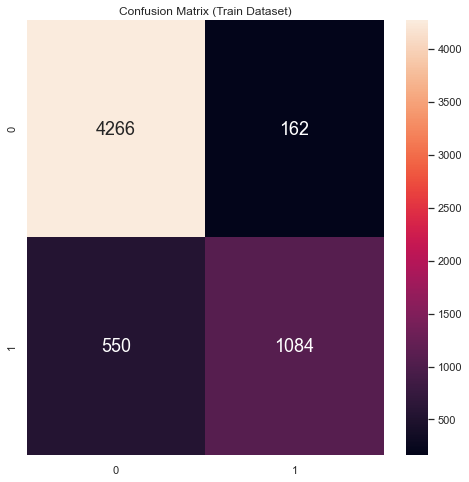

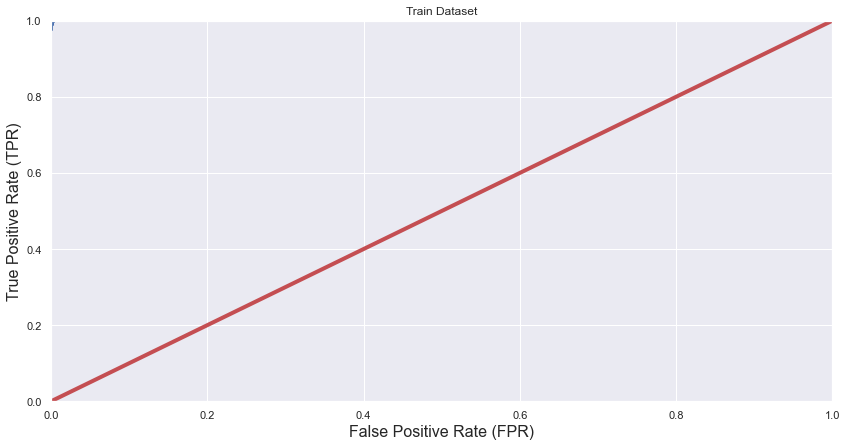

ROC-AUC-Score: 0.999952317454631


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8522506299095894
True Positive Rate: 0.8167259786476868
True Negative Rate: 0.8620520373097693

Precision: 0.8167259786476868
Recall: 0.6202702702702703
f1_score: 0.7050691244239631


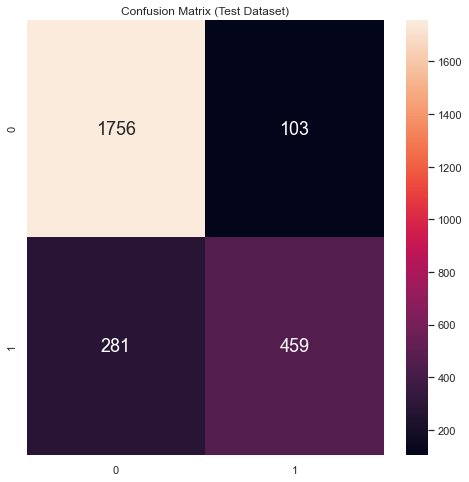

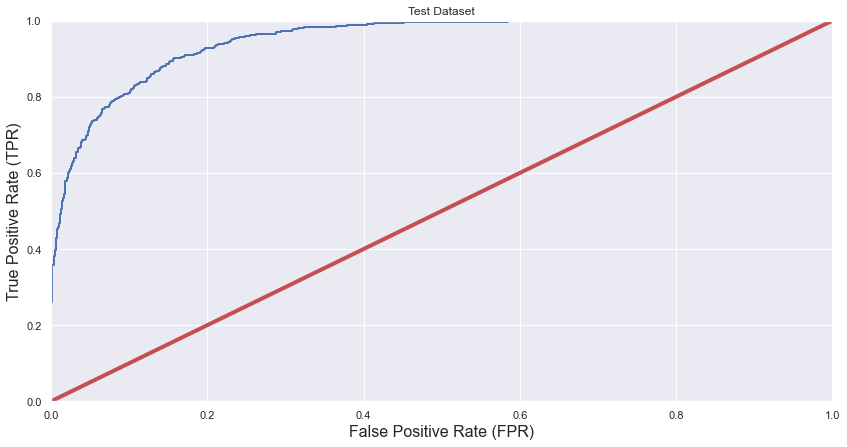

ROC-AUC-Score: 0.9487496910573834
-----

oob score: 88.77 %


In [500]:
model_performance(random_forest_v4, X_train, X_test, y_train, y_test)

**V4 Conclusion:**
- More consistent performance (even lower s.d. of classification accuracy compared to all previous versions)
- `oob_score` similar to v1 and v2, and higher than v3
- Performance on `train` dataset is similar to v1 and v2
- **Performance on `test` dataset has improved (the best among all versions):**
  - Classification Accuracy increased
  - TPR & TNR increased
  - Precision, Recall, and f1_score has slightly increased
  - ROC-AUC-Score slightly increased

## We will use `random_forest_v4 model`

In [518]:
random_forest_v4.predict(X_test.loc[:1166])[0]

1.0

In [515]:
X_test.loc[:1166]

,num_episodes,average_episode_duration,media_type_movie,media_type_music,media_type_ona,media_type_ova,media_type_special,media_type_tv,source_4_koma_manga,source_game,...,studio-0_Yumeta Company,studio-0_Zexcs,studio-0_ufotable,studio-1_A-1 Pictures,studio-1_Bridge,studio-1_Egg Firm,studio-1_Madhouse,studio-1_NA,studio-1_Satelight,studio-2_NA
1166,1,6480,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## References:
https://www.kaggle.com/code/niklasdonges/end-to-end-project-with-python/notebook